In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV


import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all cvisualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


In [3]:
df = pd.read_csv("../data/axis_bank_data_indicators.csv")
df.head()

,Date,Open Price,High,Low,Close Price,Total Traded Quantity,SMA,EWMA5,MiddleBand,UpperBand,LowerBand,RSI,MFI,ForceIndex,ATR,EMV
0,05-Dec-00,8.69,8.90,8.60,8.87,74876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06-Dec-00,8.98,9.02,8.80,8.95,61325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4906.00,0.260,NaN
2,07-Dec-00,8.92,9.08,8.92,8.94,25832,NaN,NaN,NaN,NaN,NaN,80.000000,NaN,-258.32,0.190,56.571958
3,08-Dec-00,9.05,9.30,8.93,9.10,67535,NaN,8.999692,NaN,NaN,NaN,97.297297,NaN,10805.60,0.265,59.374590
4,11-Dec-00,9.22,9.82,9.22,9.82,131575,9.136,9.314597,9.136,9.918892,8.353108,99.692308,NaN,94734.00,0.485,123.844954


In [4]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

In [9]:
# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'High',"Average Trading Price",'52 Week Low','52 Week High','MiddleBand','LowerBand','UpperBand']
temp = df
# drop_cols = ['Symbol', 'Total Traded Quantity', 'Open Price', 'Low', 'High',"Average Trading Price",'MiddleBand','LowerBand','UpperBand','Date']
# drop_cols = ['Low']
drop_cols=["Open Price","High","Low","MiddleBand","UpperBand","LowerBand"]

In [18]:
train_df.head()

,Open Price,High,Close Price,Total Traded Quantity,SMA,EWMA5,MiddleBand,UpperBand,LowerBand,RSI,MFI,ForceIndex,ATR,EMV
0,8.69,8.90,8.87,74876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.98,9.02,8.95,61325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4906.00,0.260,NaN
2,8.92,9.08,8.94,25832,NaN,NaN,NaN,NaN,NaN,80.000000,NaN,-258.32,0.190,56.571958
3,9.05,9.30,9.10,67535,NaN,8.999692,NaN,NaN,NaN,97.297297,NaN,10805.60,0.265,59.374590
4,9.22,9.82,9.82,131575,9.136,9.314597,9.136,9.918892,8.353108,99.692308,NaN,94734.00,0.485,123.844954


In [11]:

cols = ["Close Price"]
y_train = train_df['Close Price'].copy()
X_train = train_df.drop(columns=cols)

y_valid = valid_df['Close Price'].copy()
X_valid = valid_df.drop(columns=cols)

y_test  = test_df['Close Price'].copy()
X_test  = test_df.drop(columns=cols)
True
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Open Price             2992 non-null   float64
 1   High                   2992 non-null   float64
 2   Total Traded Quantity  2992 non-null   int64  
 3   SMA                    2988 non-null   float64
 4   EWMA5                  2989 non-null   float64
 5   MiddleBand             2988 non-null   float64
 6   UpperBand              2988 non-null   float64
 7   LowerBand              2988 non-null   float64
 8   RSI                    2990 non-null   float64
 9   MFI                    2979 non-null   float64
 10  ForceIndex             2991 non-null   float64
 11  ATR                    2991 non-null   float64
 12  EMV                    2990 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 304.0 KB


In [12]:
# TODO: FIX THE WARNINGS

parameters = {
    'n_estimators': range(100,1000,100),#500
    'learning_rate': [0.001, 0.005, 0.01, 0.05] ,#0.05
    'max_depth': [8, 10, 12, 15,20,32,64], #8
    'gamma': [0.001, 0.005, 0.01, 0.02],#0.001
    'random_state': [42]
}
','
eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False,random_state=42,silent=True)
clf = GridSearchCV(model, parameters,verbose=False)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')


[10:03:32] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:03:33] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:03:33] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:03:33] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:03:33] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:03:34] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:03:34] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:03:34] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:03:35] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "silent", "verbose" } are not used.

[10:03:35] WARNING: ../src/learner.cc

KeyboardInterrupt: 

In [13]:
parameters = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    # 'gamma':0.001,
    'random_state': 42
}

model = xgb.XGBRegressor(**parameters, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

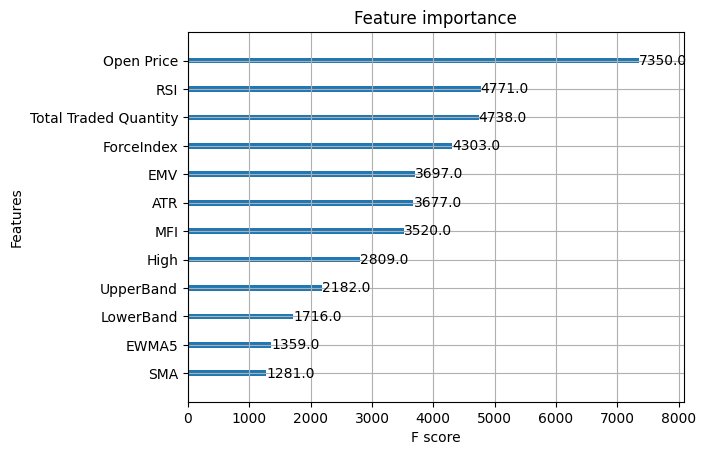

In [14]:
plot_importance(model)

In [15]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')


y_true = [583.9  585.8  577.05 571.8  578.2 ]
y_pred = [316.26318 316.49512 310.06223 306.79187 314.58676]


In [16]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 39025.3783424627


In [18]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close Price'] = y_pred
predicted_prices.head()

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=temp.index, y=df['Close Price'],
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices['Close Price'],
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_pred,
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()